# Time series transformation selection with Estimation of Distribution Algorithms

When working with Time series in a Machine Learning project it is very common to try different combinations of the time series in order to perform better the forecasting model. 

An EDA approach is presented to select the best transformations of the time series.

In [1]:
# loading essential libraries first
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# EDAspy libraries
from EDAspy.timeseries import EDA_ts_fts as EDA
from EDAspy.timeseries import TS_transformations


In [2]:
# import some data
mdata = sm.datasets.macrodata.load_pandas().data
df = mdata.iloc[:, 2:12]
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop
0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146
1,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830
2,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657
3,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386
4,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007


In [3]:
variables = list(df.columns)
variable_y = 'pop'  # pop is the variable we want to forecast
variables = list(set(variables) - {variable_y})  # array of variables to select among transformations
variables

['realinv',
 'tbilrate',
 'realgdp',
 'unemp',
 'm1',
 'cpi',
 'realdpi',
 'realcons',
 'realgovt']

Build the dataset with all the transformations desired. If some more transformations are desired, then it must be added to the dataset following the next steps:
 1. Add the transformation postfix
 2. Add to the dataset the respective variable with name (name + postfix)

In [4]:
TSTransf = TSTransformations(df)
transformations = ['detrend', 'smooth', 'log']  # postfix to variables, to denote the transformation

# build the transformations
for var in variables:
    transformation = TSTransf.de_trending(var)
    df[var + 'detrend'] = transformation

for var in variables:
    transformation = TSTransf.smoothing(var, window=10)
    df[var + 'smooth'] = transformation

for var in variables:
    transformation = TSTransf.log(var)
    df[var + 'log'] = transformation

Define the cost function to calculate the Mean Absolute Error

In [5]:
def cost_function(variables_list, nobs=20, maxlags=15, forecastings=10):
    """
    variables_list: list of variables without the variable_y
    nobs: how many observations for validation
    maxlags: previous lags used to predict
    forecasting: number of observations to predict
    
    return: MAE of the prediction with the real validation data
    """
    
    data = df[variables_list + [variable_y]]

    df_train, df_test = data[0:-nobs], data[-nobs:]

    model = VAR(df_train)
    results = model.fit(maxlags=maxlags, ic='aic')

    lag_order = results.k_ar
    array = results.forecast(df_train.values[-lag_order:], forecastings)

    variables_ = list(data.columns)
    position = variables_.index(variable_y)

    validation = [array[i][position] for i in range(len(array))]
    mae = mean_absolute_error(validation, df_test['pop'][-forecastings:])
    
    return mae

We take the normal variables without any time series transformation and try to forecast the y variable using the same cost function defined. 
This value is stored to be compared with the optimum solution found

In [24]:
mae_pre_eda = cost_function(variables)
print('MAE without using EDA:', mae_pre_eda)

MAE without using EDA: 5.091478009948458


Initialization of the initial vector of statitstics. Each variable has a 50% probability to be or not chosen

In [6]:
vector = pd.DataFrame(columns=list(variables))
vector.loc[0] = 0.5

Run the algorithm. The code will print some further information during execution

In [7]:
eda = EDA(max_it=50, dead_it=5, size_gen=15, alpha=0.7, vector=vector,
          array_transformations=transformations, cost_function=cost_function)
best_ind, best_MAE = eda.run(output=True)

[iteration: 0 ] 5.155357972950526
[iteration: 1 ] 5.246309408804405
[iteration: 2 ] 4.103723942647372
[iteration: 3 ] 4.710694858969362
[iteration: 4 ] 4.473166010597248
[iteration: 5 ] 4.913511145463962
[iteration: 6 ] 4.244706428986632
[iteration: 7 ] 3.847353187863837
[iteration: 8 ] 4.450659158760351
[iteration: 9 ] 4.723562306804138
[iteration: 10 ] 4.723562306804138
[iteration: 11 ] 4.723562306804138


# Some plots

Solution: ['realinvsmooth', 'tbilratelog', 'realgdpdetrend', 'm1detrend', 'cpibasic', 'realconssmooth', 'realgovtbasic'] 
MAE post EDA: 3.85 
MAE pre EDA: 5.09


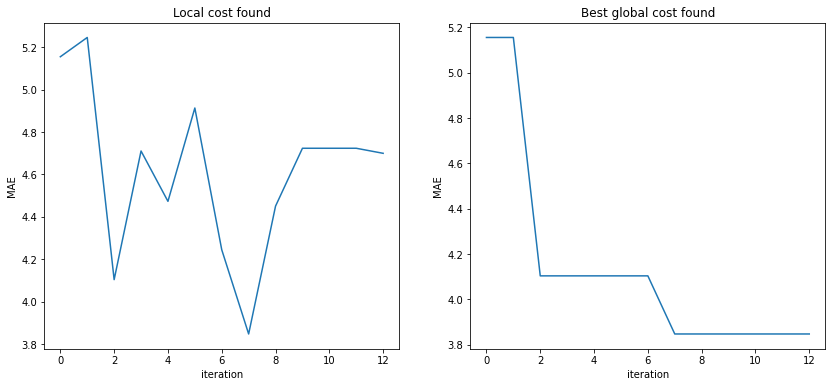

In [25]:
# some plots
hist = eda.historic_best

relative_plot = []
mx = 999999999
for i in range(len(hist)):
    if hist[i] < mx:
        mx = hist[i]
        relative_plot.append(mx)
    else:
        relative_plot.append(mx)

print('Solution:', best_ind, '\nMAE post EDA: %.2f' % best_MAE, '\nMAE pre EDA: %.2f' % mae_pre_eda)

plt.figure(figsize = (14,6))

ax = plt.subplot(121)
ax.plot(list(range(len(hist))), hist)
ax.title.set_text('Local cost found')
ax.set_xlabel('iteration')
ax.set_ylabel('MAE')

ax = plt.subplot(122)
ax.plot(list(range(len(relative_plot))), relative_plot)
ax.title.set_text('Best global cost found')
ax.set_xlabel('iteration')
ax.set_ylabel('MAE')

plt.show()